# **Klasifikasi Gambar Proyek Fundamental Deep Learning**
- **Nama:** Muhammad Makarim
- **Email:** mmakarim9@student.ub.ac.id
- **ID Dicoding:** MC006D5Y1427

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflow opencv-python

In [28]:
!pip install tensorflowjs --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [46]:
# Import library utama untuk deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Conv2D,          # Lapisan konvolusi 2D
    MaxPooling2D,    # Lapisan pooling
    Flatten,         # Meratakan input
    Dense,           # Lapisan fully connected
    Dropout,          # Mencegah overfitting
    BatchNormalization,
    InputLayer,
    GlobalAveragePooling2D
)

# Callback untuk optimasi training
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# Preprocessing dan augmentasi
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Library pendukung
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import gdown
import zipfile
import shutil
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [3]:
# Konfigurasi GPU (opsional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set random seed untuk reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## Data Preparation

### Data Loading

In [4]:
# Unduh dan ekstrak dataset
file_id = '1GR5_Y_07vHFDXRRORPhrBz-9CYdgSTkh'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

output = 'garbage_dataset.zip'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1GR5_Y_07vHFDXRRORPhrBz-9CYdgSTkh
From (redirected): https://drive.google.com/uc?export=download&id=1GR5_Y_07vHFDXRRORPhrBz-9CYdgSTkh&confirm=t&uuid=3db6c8df-3d66-4b1f-bf88-388d7a33a9b0
To: /content/garbage_dataset.zip
100%|██████████| 251M/251M [00:03<00:00, 76.1MB/s]


'garbage_dataset.zip'

In [5]:
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [6]:
# Cek isi folder setelah ekstraksi
os.listdir('/content/dataset/garbage_classification')

['brown-glass',
 'trash',
 'battery',
 'clothes',
 'shoes',
 'plastic',
 'cardboard',
 'paper',
 'white-glass',
 'metal',
 'biological',
 'green-glass']

In [7]:
# Path dataset
dataset_path = '/content/dataset/garbage_classification'
themes = dataset_path
theme_to_label = {theme: idx for idx, theme in enumerate(themes)}

In [8]:
# Path dataset
dataset_path = '/content/dataset/garbage_classification'

# Fungsi untuk menganalisis ukuran gambar per kelas
def analyze_image_sizes_per_class(path):
    # Dictionary untuk menyimpan ukuran gambar per kelas
    class_sizes = {}

    # Loop melalui semua subfolder (kelas)
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)

        # Pastikan ini adalah folder
        if os.path.isdir(class_path):
            sizes = []

            # Loop melalui gambar di folder kelas
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)

                # Pastikan file adalah gambar
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    try:
                        img = cv2.imread(img_path)

                        if img is not None:
                            height, width, _ = img.shape
                            sizes.append((width, height))
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

            # Simpan ukuran gambar untuk kelas ini
            class_sizes[class_folder] = sizes

    return class_sizes

# Analisis ukuran gambar per kelas
class_sizes = analyze_image_sizes_per_class(dataset_path)

In [9]:
# Total statistik keseluruhan
all_widths = [size[0] for sizes in class_sizes.values() for size in sizes]
all_heights = [size[1] for sizes in class_sizes.values() for size in sizes]

print("\n--- Statistik Keseluruhan ---")
print(f"Total Jumlah Gambar: {len(all_widths)}")
print(f"Lebar - Min: {min(all_widths)}, Max: {max(all_widths)}, Rata-rata: {np.mean(all_widths):.2f}")
print(f"Tinggi - Min: {min(all_heights)}, Max: {max(all_heights)}, Rata-rata: {np.mean(all_heights):.2f}")


--- Statistik Keseluruhan ---
Total Jumlah Gambar: 15515
Lebar - Min: 51, Max: 888, Rata-rata: 349.82
Tinggi - Min: 100, Max: 936, Rata-rata: 351.71


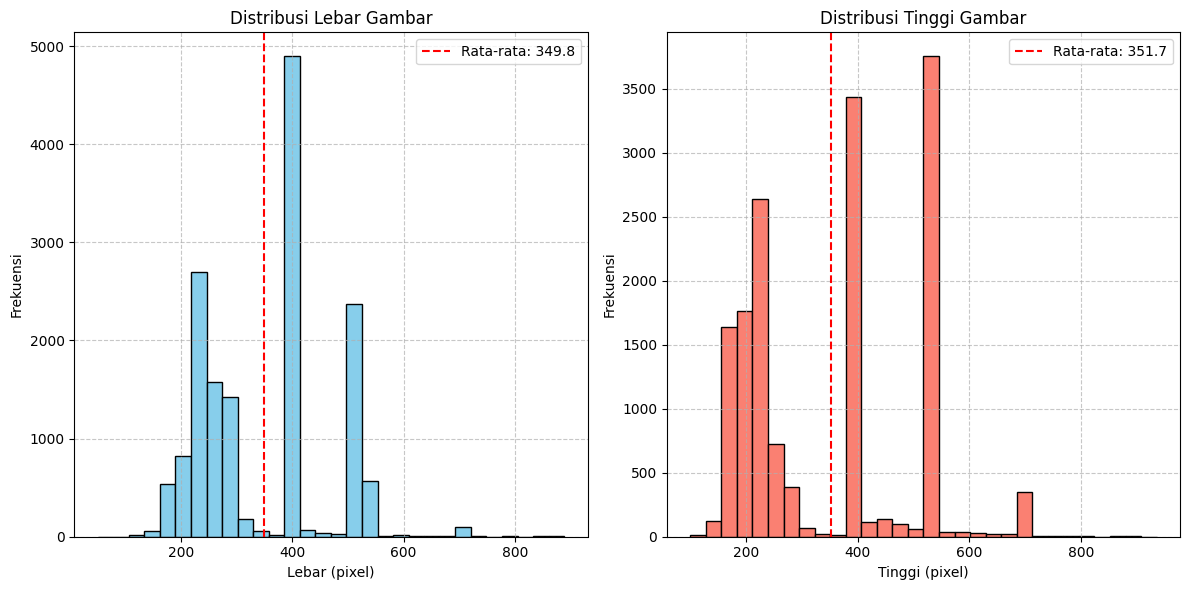

In [10]:
# Setup figure
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(all_widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Lebar Gambar')
plt.xlabel('Lebar (pixel)')
plt.ylabel('Frekuensi')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(np.mean(all_widths), color='red', linestyle='dashed', linewidth=1.5, label=f'Rata-rata: {np.mean(all_widths):.1f}')
plt.legend()

# Plot distribusi tinggi
plt.subplot(1, 2, 2)
plt.hist(all_heights, bins=30, color='salmon', edgecolor='black')
plt.title('Distribusi Tinggi Gambar')
plt.xlabel('Tinggi (pixel)')
plt.ylabel('Frekuensi')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(np.mean(all_heights), color='red', linestyle='dashed', linewidth=1.5, label=f'Rata-rata: {np.mean(all_heights):.1f}')
plt.legend()

plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

Melakukan labeling untuk split dataset nanti, serta melakukan resize pada gambar agar seragam

In [11]:
# Output folder
output_dir = '/content/garbage_resize'
os.makedirs(output_dir, exist_ok=True)

# Path dataset
dataset_path = '/content/dataset/garbage_classification'
label_records = []

# Mappingan tema ke label
themes = sorted(os.listdir(dataset_path))
theme_to_label = {theme: i for i, theme in enumerate(themes)}

for theme in themes:
    theme_path = os.path.join(dataset_path, theme)
    if not os.path.isdir(theme_path):
        continue

    # Membuat sub-folder untuk setiap tema
    theme_output_dir = os.path.join(output_dir, theme)
    os.makedirs(theme_output_dir, exist_ok=True)

    files = [f for f in os.listdir(theme_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    for file in files:
        img_path = os.path.join(theme_path, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Mengubah ukuran gambar
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)

        # Mengubah nama file sesuai dengan kelas
        new_filename = f"{theme}_{file}"
        output_filepath = os.path.join(theme_output_dir, new_filename)
        cv2.imwrite(output_filepath, img)

        label = theme_to_label[theme]
        label_records.append({'filename': new_filename, 'label': label})

# Buat DataFrame label
df_labels = pd.DataFrame(label_records, columns=['filename', 'label'])
df_labels.to_csv(os.path.join(output_dir, 'labels.csv'), index=False)

# Informasi label
print(f"Jumlah label: {len(label_records)}")
print(f"Contoh label:\n{df_labels.head()}")

Jumlah label: 15515
Contoh label:
                 filename  label
0  battery_battery517.jpg      0
1  battery_battery647.jpg      0
2  battery_battery660.jpg      0
3  battery_battery254.jpg      0
4  battery_battery121.jpg      0


Split dataset yang sudah di labeling dan di resize

In [12]:
# Path dataset
dataset_path = '/content/garbage_resize'
output_dir = 'Data_split_garbage_2'

# Membuat folder utama untuk menyimpan dataset yang telah dibagi
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

# Daftar kelas
classes = [
 'brown-glass',
 'trash',
 'battery',
 'clothes',
 'shoes',
 'plastic',
 'cardboard',
 'paper',
 'white-glass',
 'metal',
 'biological',
 'green-glass']

# Iterasi melalui setiap kelas
for cls in classes:
    class_folder = os.path.join(dataset_path, cls)

    if not os.path.isdir(class_folder):
        continue

    # Dapatkan semua gambar di dalam kelas
    images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_paths = [os.path.join(class_folder, img) for img in images]

    # Split dataset (80% train, 10% val, 10% test)
    train_imgs, temp_imgs = train_test_split(image_paths, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.3333, random_state=42)

    # Fungsi untuk menyimpan gambar yang telah diresize
    def save_resized_images(image_list, split):
        split_folder = os.path.join(output_dir, split, cls)
        os.makedirs(split_folder, exist_ok=True)

        for img_path in image_list:
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (224, 224))  # Resize ke 640x640
                # Simpan gambar dengan nama yang sama
                cv2.imwrite(os.path.join(split_folder, os.path.basename(img_path)), img_resized)

    # Simpan gambar yang telah dibagi dan diresize
    save_resized_images(train_imgs, 'train')
    save_resized_images(val_imgs, 'val')
    save_resized_images(test_imgs, 'test')

Membuat Generator

In [13]:
# Path ke dataset
train_dir = 'Data_split_garbage_2/train'
val_dir = 'Data_split_garbage_2/val'
test_dir = 'Data_split_garbage_2/test'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Definisi test_generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10854 images belonging to 12 classes.
Found 3105 images belonging to 12 classes.
Found 1556 images belonging to 12 classes.


## Modelling

In [14]:
# Membangun Model dengan Sequential dan MobileNetV2
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze layer awal

# Buat model akhir
model = models.Sequential([
    base_model,
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    layers.Dense(12, activation='softmax', kernel_regularizer=l2(0.001))
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7256 - loss: 1.2286

340/340 ━━━━━━━━━━━━━━━━━━━━ 775s 2s/step - accuracy: 0.7259 - loss: 1.2277 - val_accuracy: 0.9108 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 2/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8878 - loss: 0.6525

340/340 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step - accuracy: 0.8878 - loss: 0.6524 - val_accuracy: 0.9224 - val_loss: 0.5060 - learning_rate: 0.0010
Epoch 3/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9084 - loss: 0.5228

340/340 ━━━━━━━━━━━━━━━━━━━━ 759s 2s/step - accuracy: 0.9084 - loss: 0.5228 - val_accuracy: 0.9311 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 4/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9258 - loss: 0.4376

340/340 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - accuracy: 0.9258 - loss: 0.4376 - val_accuracy: 0.9320 - val_loss: 0.4028 - learning_rate: 0.0010
Epoch 5/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9343 - loss: 0.3824 - val_accuracy: 0.9246 - val_loss: 0.3979 - learning_rate: 0.0010
Epoch 6/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9376 - loss: 0.3350

340/340 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.9376 - loss: 0.3351 - val_accuracy: 0.9359 - val_loss: 0.3530 - learning_rate: 0.0010
Epoch 7/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - accuracy: 0.9464 - loss: 0.3080 - val_accuracy: 0.9359 - val_loss: 0.3289 - learning_rate: 0.0010
Epoch 8/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9529 - loss: 0.2705 - val_accuracy: 0.9353 - val_loss: 0.3329 - learning_rate: 0.0010
Epoch 9/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9472 - loss: 0.2611 - val_accuracy: 0.9349 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 10/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9516 - loss: 0.2445 - val_accuracy: 0.9340 - val_loss: 0.3034 - learning_rate: 0.0010
Epoch 11/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9545 - loss: 0.2361 - val_accuracy: 0.9353 - val_loss: 0.3422 - learning_rate: 0.0010
Epoch 12/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.9573 - loss: 0.2302 - v

340/340 ━━━━━━━━━━━━━━━━━━━━ 754s 2s/step - accuracy: 0.9613 - loss: 0.2087 - val_accuracy: 0.9362 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 14/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9613 - loss: 0.2105

340/340 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.9613 - loss: 0.2105 - val_accuracy: 0.9388 - val_loss: 0.3173 - learning_rate: 0.0010
Epoch 15/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - loss: 0.1986
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
340/340 ━━━━━━━━━━━━━━━━━━━━ 757s 2s/step - accuracy: 0.9638 - loss: 0.1986 - val_accuracy: 0.9353 - val_loss: 0.3307 - learning_rate: 0.0010
Epoch 16/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9702 - loss: 0.1774

340/340 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9702 - loss: 0.1774 - val_accuracy: 0.9446 - val_loss: 0.2955 - learning_rate: 2.0000e-04
Epoch 17/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9761 - loss: 0.1563

340/340 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.9761 - loss: 0.1563 - val_accuracy: 0.9491 - val_loss: 0.2720 - learning_rate: 2.0000e-04
Epoch 18/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.9810 - loss: 0.1396 - val_accuracy: 0.9481 - val_loss: 0.2775 - learning_rate: 2.0000e-04
Epoch 19/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 800s 2s/step - accuracy: 0.9804 - loss: 0.1373 - val_accuracy: 0.9469 - val_loss: 0.2735 - learning_rate: 2.0000e-04
Epoch 20/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9783 - loss: 0.1406

340/340 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.9783 - loss: 0.1406 - val_accuracy: 0.9494 - val_loss: 0.2683 - learning_rate: 2.0000e-04
Epoch 21/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - accuracy: 0.9782 - loss: 0.1359 - val_accuracy: 0.9459 - val_loss: 0.2683 - learning_rate: 2.0000e-04
Epoch 22/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - accuracy: 0.9790 - loss: 0.1332 - val_accuracy: 0.9456 - val_loss: 0.2818 - learning_rate: 2.0000e-04
Epoch 23/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 767s 2s/step - accuracy: 0.9816 - loss: 0.1281 - val_accuracy: 0.9449 - val_loss: 0.2681 - learning_rate: 2.0000e-04
Epoch 24/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 753s 2s/step - accuracy: 0.9840 - loss: 0.1213 - val_accuracy: 0.9452 - val_loss: 0.2710 - learning_rate: 2.0000e-04
Epoch 25/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.9845 - loss: 0.1184 - val_accuracy: 0.9478 - val_loss: 0.2672 - learning_rate: 2.0000e-04


## Evaluasi dan Visualisasi

In [18]:
# Evaluasi Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9519 - loss: 0.2412
Test Loss: 0.2976, Test Accuracy: 0.9402


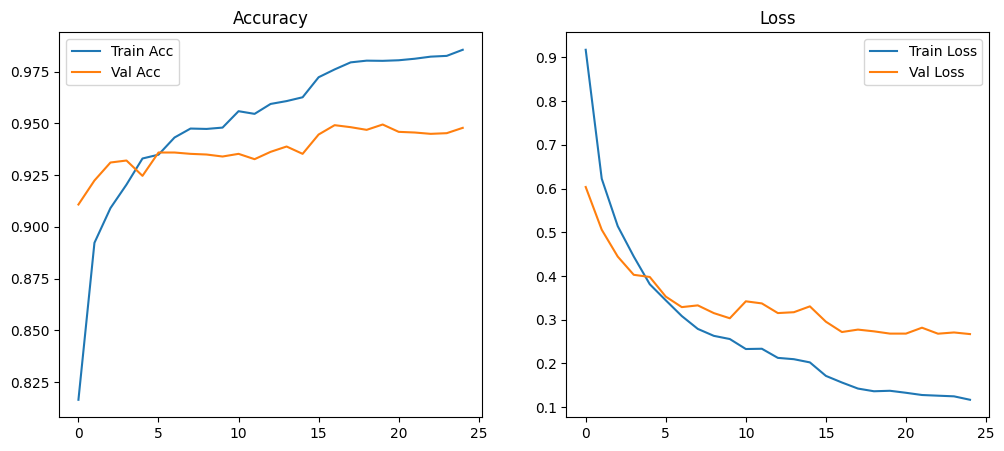

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

## Konversi Model

**Saved Model**

In [21]:
model.save('saved_model_garbage.keras')

In [23]:
model = load_model("saved_model_garbage.keras")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,343,066 (20.38 MB)

 Trainable params: 1,542,412 (5.88 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

 Optimizer params: 1,542,414 (5.88 MB)

In [24]:
model.export("saved_model_garbage")

Saved artifact at 'saved_model_garbage'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  140372926018384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372926018000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372926018960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372926016080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372926017616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889351568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889346768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889350416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889351184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889350608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889

TF Lite

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('garbage_odel.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp3cg4uak0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  140372926018384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372926018000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372926018960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372926016080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372926017616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889351568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889346768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889350416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889351184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889350608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140372889349

In [26]:
# Create the labels file
labels = train_generator.class_indices
sorted_labels = sorted(labels.items(), key=lambda item: item[1])
class_names = [name for name, index in sorted_labels]

with open('labels.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

**TFJS**

In [29]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model_garbage tfjs_model_garbage/

2025-06-16 06:46:34.203497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750056394.276176   85861 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750056394.315457   85861 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-16 06:46:46.330216: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1750056408.264893   85861 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

**Save model**

In [30]:
!zip -r saved_model_garbage.zip saved_model_garbage/

  adding: saved_model_garbage/ (stored 0%)
  adding: saved_model_garbage/assets/ (stored 0%)
  adding: saved_model_garbage/fingerprint.pb (stored 0%)
  adding: saved_model_garbage/variables/ (stored 0%)
  adding: saved_model_garbage/variables/variables.index (deflated 78%)
  adding: saved_model_garbage/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model_garbage/saved_model.pb (deflated 90%)


In [31]:
!zip -r tfjs_model_garbage.zip tfjs_model_garbage/

  adding: tfjs_model_garbage/ (stored 0%)
  adding: tfjs_model_garbage/group1-shard3of4.bin (deflated 7%)
  adding: tfjs_model_garbage/group1-shard4of4.bin (deflated 7%)
  adding: tfjs_model_garbage/group1-shard1of4.bin (deflated 7%)
  adding: tfjs_model_garbage/model.json (deflated 96%)
  adding: tfjs_model_garbage/group1-shard2of4.bin (deflated 7%)


## Inference (Optional)

**Keras Model**

In [38]:
try:
    keras_model = load_model('/content/saved_model_garbage.keras')
    print("Keras model loaded successfully.")
except Exception as e:
    print(f"Error loading Keras model: {e}")
    keras_model = None

Keras model loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- Performing Keras Model Inference on Example Images ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Image: battery_battery419.jpg
Predicted class (Keras): battery (Confidence: 0.9997)


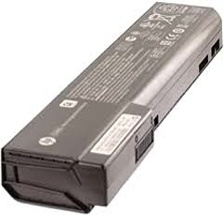

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Image: metal_metal152.jpg
Predicted class (Keras): metal (Confidence: 0.9998)


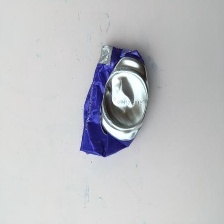

------------------------------


In [42]:
if keras_model:
    inference_class_names_keras = sorted(os.listdir(test_dir))
    if not inference_class_names_keras:
         if train_generator and hasattr(train_generator, 'class_indices'):
              sorted_labels = sorted(train_generator.class_indices.items(), key=lambda item: item[1])
              inference_class_names_keras = [name for name, index in sorted_labels]
         else:
              print("Warning: Could not determine class names for Keras inference.")
              inference_class_names_keras = None # Cannot proceed without class names

    if inference_class_names_keras:
        def predict_image_keras(image_path, model, class_names):
            try:
                img = image.load_img(image_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)

                # Make prediction
                predictions = model.predict(img_array)

                # Get the predicted class index
                predicted_class_index = np.argmax(predictions, axis=1)[0]
                predicted_class_name = class_names[predicted_class_index]
                confidence = np.max(predictions, axis=1)[0]

                print(f"Image: {os.path.basename(image_path)}")
                print(f"Predicted class (Keras): {predicted_class_name} (Confidence: {confidence:.4f})")
                try:
                    display(Image(filename=image_path))
                except NameError:
                    print("Could not display image. Make sure 'from IPython.display import Image, display' is imported.")
                print("-" * 30)

            except FileNotFoundError:
                print(f"Error: Image not found at {image_path}")
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")


        # --- Example Usage for Keras Model ---
        print("\n--- Performing Keras Model Inference on Example Images ---")

        example_image_paths_keras = [
            '/content/Data_split_garbage_2/test/battery/battery_battery419.jpg',
            '/content/Data_split_garbage_2/test/metal/metal_metal152.jpg',
        ]

        # Check if example images exist before trying to predict
        valid_example_images_keras = [img_path for img_path in example_image_paths_keras if os.path.exists(img_path)]

        if valid_example_images_keras:
            for img_path in valid_example_images_keras:
                predict_image_keras(img_path, keras_model, inference_class_names_keras)
        else:
            print("No valid example image paths found for Keras inference. Please update 'example_image_paths_keras'.")

else:
    print("Keras model was not loaded, skipping Keras inference.")

**TF Lite**

In [43]:
# Load the TFLite model and allocate tensors
try:
    interpreter = tf.lite.Interpreter(model_path="garbage_odel.tflite")
    interpreter.allocate_tensors()
    print("TFLite interpreter loaded successfully.")
except Exception as e:
    print(f"Error loading TFLite model: {e}")
    interpreter = None

TFLite interpreter loaded successfully.


Loaded 12 class names from labels.txt

--- Performing TFLite Model Inference on Example Images ---
Image: white-glass_white-glass151.jpg
Predicted class (TFLite): white-glass (Confidence: 0.9999)


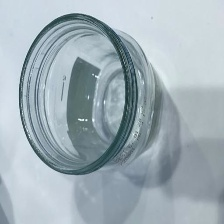

------------------------------
Image: cardboard_cardboard123.jpg
Predicted class (TFLite): cardboard (Confidence: 0.9957)


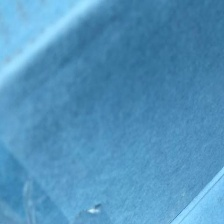

------------------------------
Image: clothes_clothes1690.jpg
Predicted class (TFLite): clothes (Confidence: 1.0000)


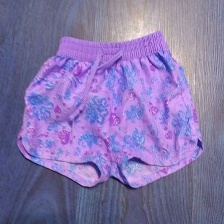

------------------------------
Image: biological_biological180.jpg
Predicted class (TFLite): biological (Confidence: 0.9988)


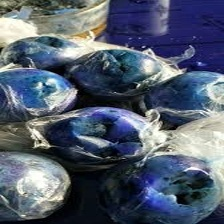

------------------------------
Image: plastic_plastic61.jpg
Predicted class (TFLite): plastic (Confidence: 0.9998)


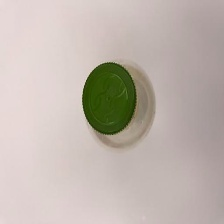

------------------------------


In [45]:
if interpreter:
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Get the expected input shape
    input_shape = input_details[0]['shape']
    try:
        with open('labels.txt', 'r') as f:
            inference_class_names_tflite = [line.strip() for line in f]
        print(f"Loaded {len(inference_class_names_tflite)} class names from labels.txt")
    except FileNotFoundError:
        print("Error: labels.txt not found. Cannot perform TFLite inference.")
        inference_class_names_tflite = None # Cannot proceed

    if inference_class_names_tflite:
        def predict_image_tflite(image_path, interpreter, input_details, output_details, class_names):
            try:
                img = image.load_img(image_path, target_size=(input_shape[1], input_shape[2])) # Use input_shape for target_size
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array) # Apply the same preprocessing as training

                input_data = img_array.astype('float32')
                interpreter.set_tensor(input_details[0]['index'], input_data)

                # Run the inference
                interpreter.invoke()

                # Get the output tensor
                output_data = interpreter.get_tensor(output_details[0]['index'])
                predictions = output_data[0]
                predicted_class_index = np.argmax(predictions)
                predicted_class_name = class_names[predicted_class_index]
                confidence = np.max(predictions)

                print(f"Image: {os.path.basename(image_path)}")
                print(f"Predicted class (TFLite): {predicted_class_name} (Confidence: {confidence:.4f})")
                try:
                    display(Image(filename=image_path))
                except NameError:
                    print("Could not display image. Make sure 'from IPython.display import Image, display' is imported.")
                print("-" * 30)


            except FileNotFoundError:
                print(f"Error: Image not found at {image_path}")
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

        print("\n--- Performing TFLite Model Inference on Example Images ---")

        example_image_paths_tflite = [
            '/content/Data_split_garbage_2/test/white-glass/white-glass_white-glass151.jpg', # Example path from your test set
            '/content/Data_split_garbage_2/test/cardboard/cardboard_cardboard123.jpg',
            '/content/Data_split_garbage_2/test/clothes/clothes_clothes1690.jpg',
            '/content/Data_split_garbage_2/test/biological/biological_biological180.jpg',
            '/content/Data_split_garbage_2/test/plastic/plastic_plastic61.jpg'

        ]

        # Check if example images exist before trying to predict
        valid_example_images_tflite = [img_path for img_path in example_image_paths_tflite if os.path.exists(img_path)]

        if valid_example_images_tflite:
            for img_path in valid_example_images_tflite:
                predict_image_tflite(img_path, interpreter, input_details, output_details, inference_class_names_tflite)
        else:
             print("No valid example image paths found for TFLite inference. Please update 'example_image_paths_tflite'.")

else:
    print("TFLite interpreter was not loaded, skipping TFLite inference.")